<a href="https://colab.research.google.com/github/wvirany/stat_learning/blob/validation_set/regression/auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Polynomial Regression and Model Selection w/ Cross Validation

---

Walter Virany

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Reading in Auto data (used from ISL w/ Python)

Auto = pd.read_csv("Auto.csv",
                   na_values=['?'])

Auto.dropna(inplace=True)   # Drop columns with '?' representing NaN

In [4]:
X = Auto['horsepower']
X = np.array(X).reshape(-1,1) # The LinearRegression from sklearn expects a 2D array for X, so I reshape here
y = Auto['mpg']

In [5]:
# Splitting our data into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

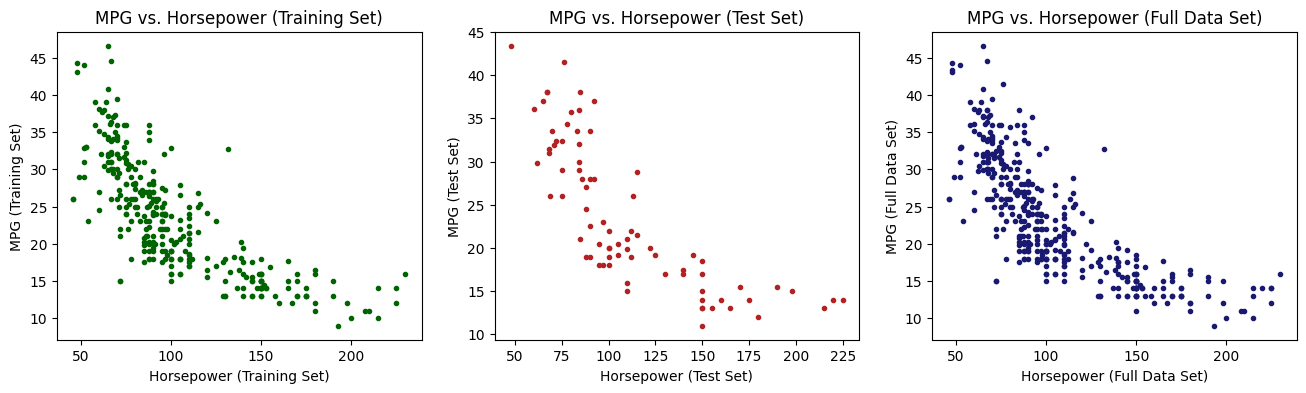

In [6]:
# It's always a good idea to plot the data first

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

axes[0].scatter(X_train, y_train, marker='.', c='darkgreen')
axes[0].set_xlabel('Horsepower (Training Set)')
axes[0].set_ylabel("MPG (Training Set)")
axes[0].set_title("MPG vs. Horsepower (Training Set)")

axes[1].scatter(X_test, y_test, marker='.', c='firebrick')
axes[1].set_xlabel('Horsepower (Test Set)')
axes[1].set_ylabel("MPG (Test Set)")
axes[1].set_title("MPG vs. Horsepower (Test Set)")

axes[2].scatter(X, y, marker='.', c='midnightblue')
axes[2].set_xlabel('Horsepower (Full Data Set)')
axes[2].set_ylabel("MPG (Full Data Set)")
axes[2].set_title("MPG vs. Horsepower (Full Data Set)");

Let's start by trying a linear model:

In [7]:
model = LinearRegression()
model.fit(X_train,y_train);

In [8]:
y_pred = model.predict(X_test)

print("Linear Coefficient:", model.coef_[0], model.intercept_)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R squared:", r2_score(y_test, y_pred))

Linear Coefficient: -0.15790917943623595 39.65769978880898
Mean Squared Error: 28.66013202298904
R squared: 0.5865667722428769


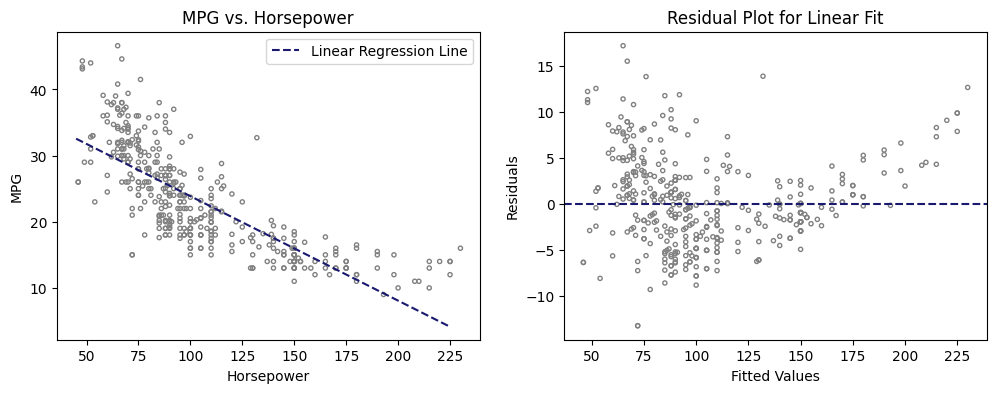

In [9]:
x_seq = np.arange(45, 225)
y_seq = x_seq * model.coef_[0] + model.intercept_
y_i = model.predict(X)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].scatter(X, y, marker='.', facecolors='none', edgecolors='grey')
axes[0].plot(x_seq, y_seq, linestyle='dashed', c='midnightblue', label='Linear Regression Line')
axes[0].set_xlabel('Horsepower')
axes[0].set_ylabel('MPG')
axes[0].set_title('MPG vs. Horsepower')
axes[0].legend()

axes[1].scatter(X, (y-y_i), marker='.', facecolors='none', edgecolors='grey')
axes[1].axhline(linestyle='dashed', c='midnightblue')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot for Linear Fit');

So, it seems like there could be a nonlinear relationship. Let's try a new model, with the assumption:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2^2
$$

This is still a linear regression model, in which we transform our original predictors, with $X_1 =$ `horsepower` and $X_2 =$ `horsepower`$^2$. So, I use the `PolynomialFeatures()` method to transform the feature vector $X$ into a 2D Vandermonde matrix.

In [10]:
# Transforming our features:

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_train = poly.fit_transform(X_train)
poly_features_test = poly.fit_transform(X_test)
poly_features = poly.fit_transform(X)

# Fitting the model:

poly_model = LinearRegression()
poly_model.fit(poly_features_train, y_train);

In [11]:
y_pred_poly = poly_model.predict(poly_features_test)

print("Coefficients:", poly_model.coef_)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_poly))
print("R squared:", r2_score(y_test, y_pred_poly))

Coefficients: [-0.44807547  0.00117254]
Mean Squared Error: 21.396565697839275
R squared: 0.6913464595250509


Seems like a better result! Let's take a look at the visualizations.

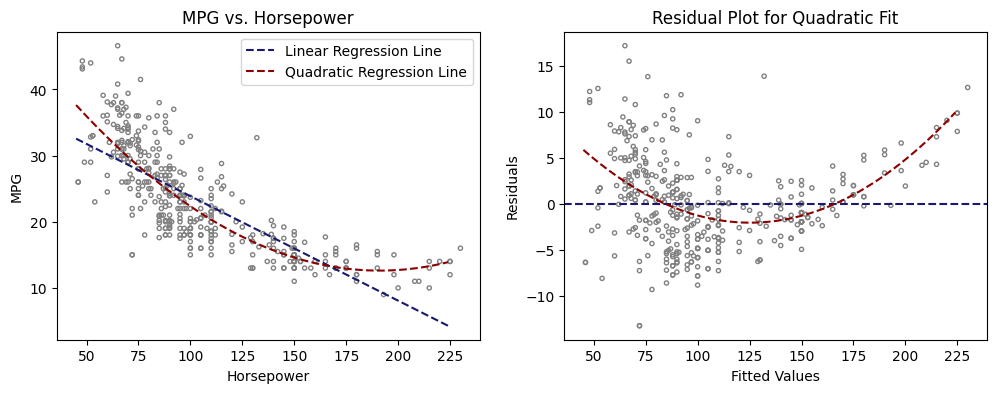

In [12]:
poly_seq = poly_model.coef_[1] * x_seq**2 + poly_model.coef_[0] * x_seq + poly_model.intercept_

residual_fit = LinearRegression()
residual_fit.fit(poly_features, (y-y_i))
resid_seq = residual_fit.coef_[1] * x_seq**2 + residual_fit.coef_[0] * x_seq + residual_fit.intercept_

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axes[0].scatter(X, y, marker='.', facecolor='none', edgecolor='grey')
axes[0].plot(x_seq, y_seq, linestyle='dashed', c='midnightblue', label='Linear Regression Line')
axes[0].plot(x_seq, poly_seq, linestyle='dashed', c='darkred', label='Quadratic Regression Line')
axes[0].set_xlabel('Horsepower')
axes[0].set_ylabel('MPG')
axes[0].set_title('MPG vs. Horsepower')
axes[0].legend()

axes[1].scatter(X, (y-y_i), marker='.', facecolors='none', edgecolors='grey')
axes[1].axhline(linestyle='dashed', c='midnightblue')
axes[1].plot(x_seq, resid_seq, linestyle='dashed', c='darkred')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot for Quadratic Fit');

It looks like the quadratic regression model for `mpg` on `horsepower` is much more accurate. The natural question to ask now is, would a cubic regression model be better? It is easy to see how this question could go on indefinitiely - quickly resulting in a model that overfits the data. In order to determine which degree of polynomial is best, I am going to use cross validation to analyze the accuracy of polynomial models up to degree 10.

First, I will use the validation set approach, in which I split the data in half, with one set used to train the model and the other to test it.

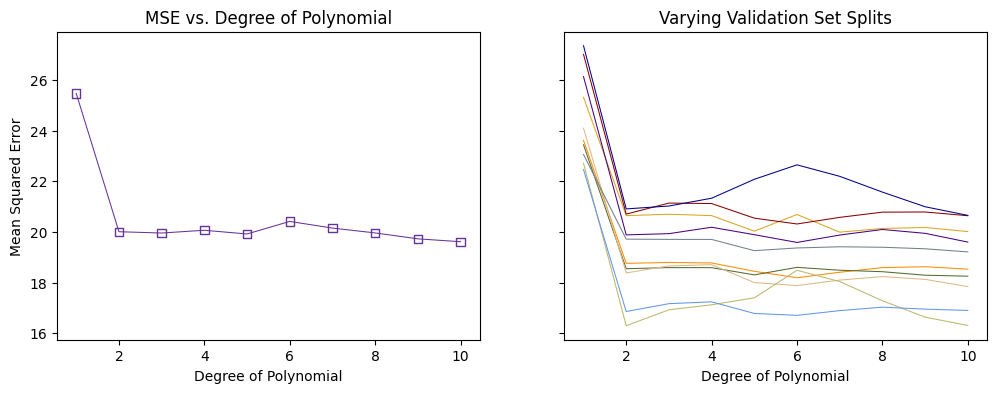

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)
mse = []
colors = ['darkorange', 'darkolivegreen', 'goldenrod', 'burlywood', 'darkkhaki',
          'slategrey', 'darkred', 'indigo', 'darkblue', 'cornflowerblue']

# Performing validation set approach once:

for i in range(1, 11):
  val_model_features = PolynomialFeatures(degree=i, include_bias=False)
  val_train = val_model_features.fit_transform(X_train)
  val_test = val_model_features.fit_transform(X_test)

  val_model = LinearRegression()
  val_model.fit(val_train, y_train)

  val_pred = val_model.predict(val_test)

  mse.append(mean_squared_error(y_test, val_pred))

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))

axes[0].plot(np.arange(1, 11), mse, lw=.75, ls='solid', c='rebeccapurple')
axes[0].scatter(np.arange(1, 11), mse, marker='s', fc='none', ec='rebeccapurple')
axes[0].set_xlabel('Degree of Polynomial')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE vs. Degree of Polynomial');

# Performing validation approach ten times, each with a different random split:

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2*i)
  mse = []

  for j in range(1, 11):
    val_model_features = PolynomialFeatures(degree=j, include_bias=False)
    val_train = val_model_features.fit_transform(X_train)
    val_test = val_model_features.fit_transform(X_test)

    val_model = LinearRegression()
    val_model.fit(val_train, y_train)

    val_pred = val_model.predict(val_test)

    mse.append(mean_squared_error(y_test, val_pred))

  axes[1].plot(np.arange(1, 11), mse, lw=.75, ls='solid', c=colors[i])
  axes[1].set_xlabel('Degree of Polynomial')
  axes[1].set_title('Varying Validation Set Splits')

In the lefthand figure, we see that the quadratic model is a significant improvement over the linear model. Furthermore, we see that there is no significant improvement in our model as we increase the degree of polynomial beyond 2. Thus, adding a cubic term to the regression model does not yield a more accurate prediction.

The righthand figure shows the validation set approach for 10 different random splits of the data into the training and test sets. Each of these curves demonstrate further evidence that the quadratic model is more robust than the linear model, but there is no consensus on which model yields the smallest test MSE.

This highlights two important drawbacks of this approach:

1. The validation estimate of the test error rate can be highly variable - depending on precisely which observations are included in the training and test sets.

2. Statistical models tend to perform better given more observations. Thus, the validation set error rate tends to overestimate the test error rate compared to the model fit on the entire data set.